# Import necessarry library dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import datasets

In [4]:
#Dataset paths
trainpath = r'/content/drive/MyDrive/modified-dataset/train'
validpath = r'/content/drive/MyDrive/modified-dataset/val'
testpath  = r'/content/drive/MyDrive/modified-dataset/test'

# Understand the Data

In [5]:
# 1EXPLORE AND UNDERSTAND THE DATA
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

datatrain = tf.keras.utils.image_dataset_from_directory(trainpath, shuffle=True, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
datavalid = tf.keras.utils.image_dataset_from_directory(validpath, shuffle=True, image_size=IMG_SIZE, batch_size=BATCH_SIZE)
datatest  = tf.keras.utils.image_dataset_from_directory(testpath, shuffle=False, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

class_names = datatrain.class_names
print(f"Classes: {class_names}")

Found 2410 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 310 files belonging to 10 classes.
Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


# Visualize samples

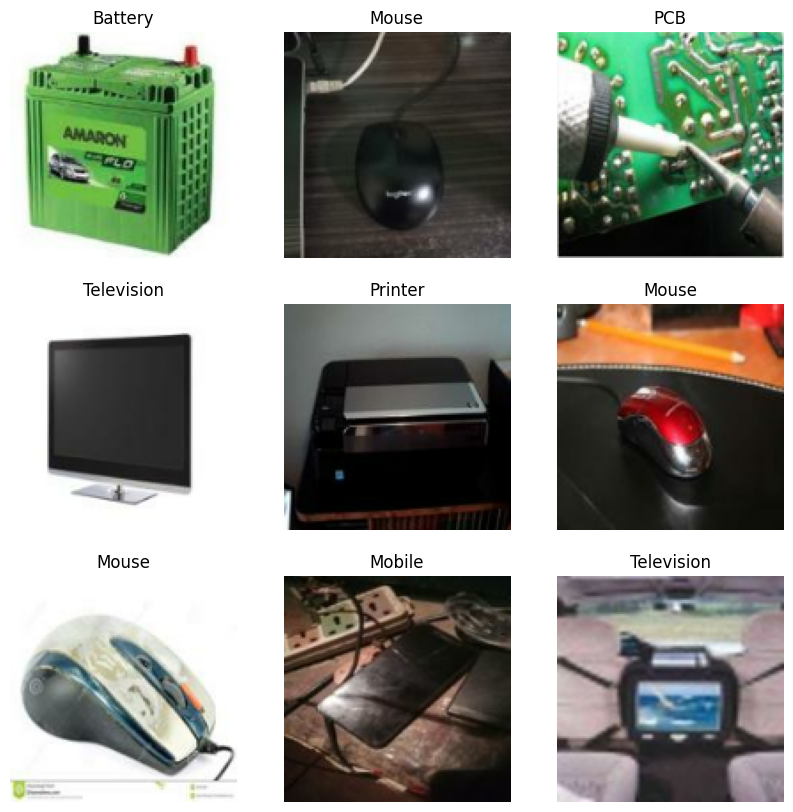

In [6]:
# Visualize samples
plt.figure(figsize=(10,10))
for images, labels in datatrain.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

# Plot class distribution

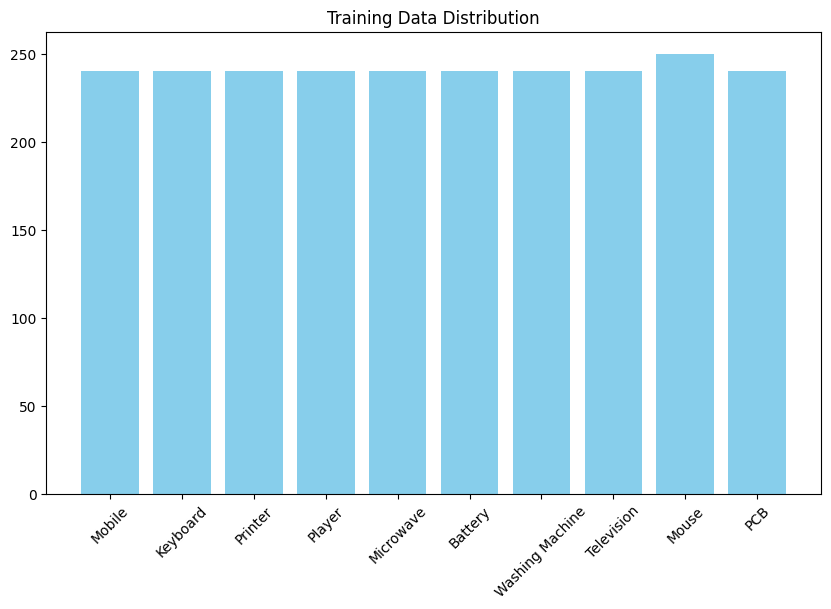

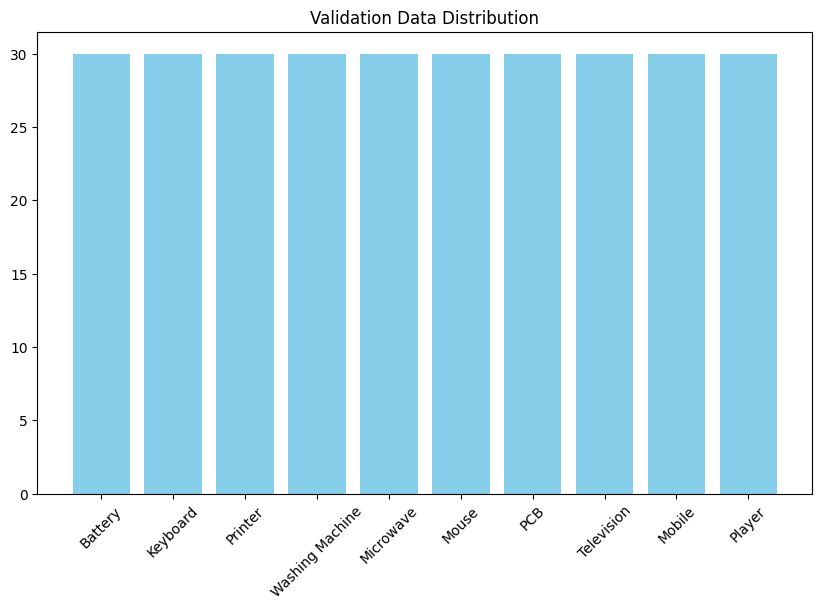

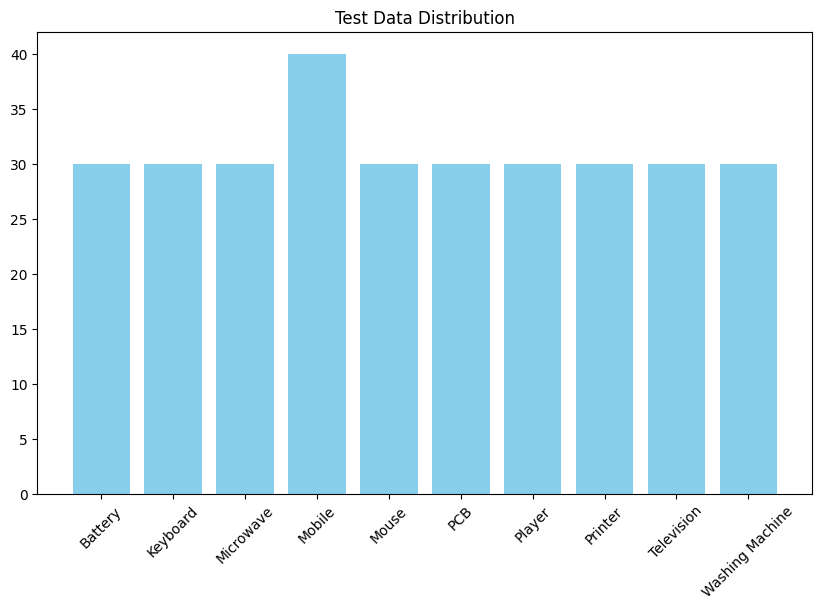

In [7]:
# Plot class distribution
def plot_class_distribution(dataset, title):
    counts = {}
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            counts[class_name] = counts.get(class_name, 0) + 1
    plt.figure(figsize=(10,6))
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")


# DATA PREPROCESSING

In [8]:
# DATA PREPROCESSING / PREPARATION
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

datatrain = datatrain.prefetch(tf.data.AUTOTUNE)
datavalid = datavalid.prefetch(tf.data.AUTOTUNE)
datatest  = datatest.prefetch(tf.data.AUTOTUNE)

# MODEL SELECTION USING EFFICIENTNET

In [9]:
# MODEL SELECTION
base_model = EfficientNetV2B0(input_shape=IMG_SIZE+(3,), include_top=False, weights='imagenet')
for layer in base_model.layers[:100]:
    layer.trainable = False

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = models.Model(inputs, outputs)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# MODEL TRAINING

In [10]:
# MODEL TRAINING
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

history = model.fit(datatrain, validation_data=datavalid, epochs=15, callbacks=[early_stop, reduce_lr])

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 51s 183ms/step - accuracy: 0.2921 - loss: 2.0460 - val_accuracy: 0.7967 - val_loss: 1.0489 - learning_rate: 1.0000e-04
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.7852 - loss: 0.9561 - val_accuracy: 0.8900 - val_loss: 0.4801 - learning_rate: 1.0000e-04
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.8765 - loss: 0.4865 - val_accuracy: 0.9267 - val_loss: 0.2935 - learning_rate: 1.0000e-04
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9105 - loss: 0.3234 - val_accuracy: 0.9567 - val_loss: 0.2241 - learning_rate: 1.0000e-04
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9268 - loss: 0.2303 - val_accuracy: 0.9633 - val_loss: 0.1834 - learning_rate: 1.0000e-04
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.9395 - loss: 0.2093 - val_accuracy: 0.9600 - val_loss: 0.1685 - learning_rate: 1.0000e-04
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accu

# MODEL TUNING AND OPTIMIZATION

In [11]:
# MODEL TUNING AND OPTIMIZATION (optional fine-tune)
for layer in base_model.layers[100:]:
    layer.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(datatrain, validation_data=datavalid, epochs=5, callbacks=[early_stop, reduce_lr])

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 179ms/step - accuracy: 0.9864 - loss: 0.0595 - val_accuracy: 0.9700 - val_loss: 0.1295 - learning_rate: 1.0000e-05
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9882 - loss: 0.0549 - val_accuracy: 0.9667 - val_loss: 0.1223 - learning_rate: 1.0000e-05
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.9836 - loss: 0.0571 - val_accuracy: 0.9700 - val_loss: 0.1313 - learning_rate: 1.0000e-05
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9875 - loss: 0.0465 - val_accuracy: 0.9633 - val_loss: 0.1313 - learning_rate: 1.0000e-05
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.9919 - loss: 0.0384 - val_accuracy: 0.9667 - val_loss: 0.1310 - learning_rate: 5.0000e-06


# MODEL PERFORMANCE VISUALIZATION

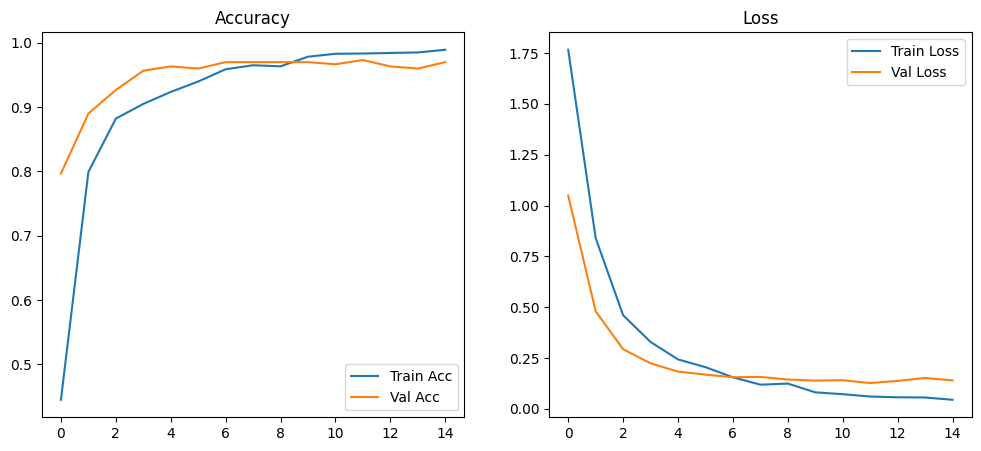

In [12]:
# MODEL PERFORMANCE VISUALIZATION
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# MODEL EVALUATION AND CONFUSION MATRIX

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9483 - loss: 0.1628
Test Accuracy: 0.9613, Test Loss: 0.1219
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 462ms/step
                 precision    recall  f1-score   support

        Battery       0.96      0.87      0.91        30
       Keyboard       1.00      1.00      1.00        30
      Microwave       0.88      0.93      0.90        30
         Mobile       1.00      1.00      1.00        40
          Mouse       1.00      1.00      1.00        30
            PCB       0.94      0.97      0.95        30
         Player       0.93      0.93      0.93        30
        Printer       0.94      1.00      0.97        30
     Television       0.96      0.90      0.93        30
Washing Machine       1.00      1.00      1.00        30

       accuracy                           0.96       310
      macro avg       0.96      0.96      0.96       310
   weighted avg       0.96      0.96      0.96       310



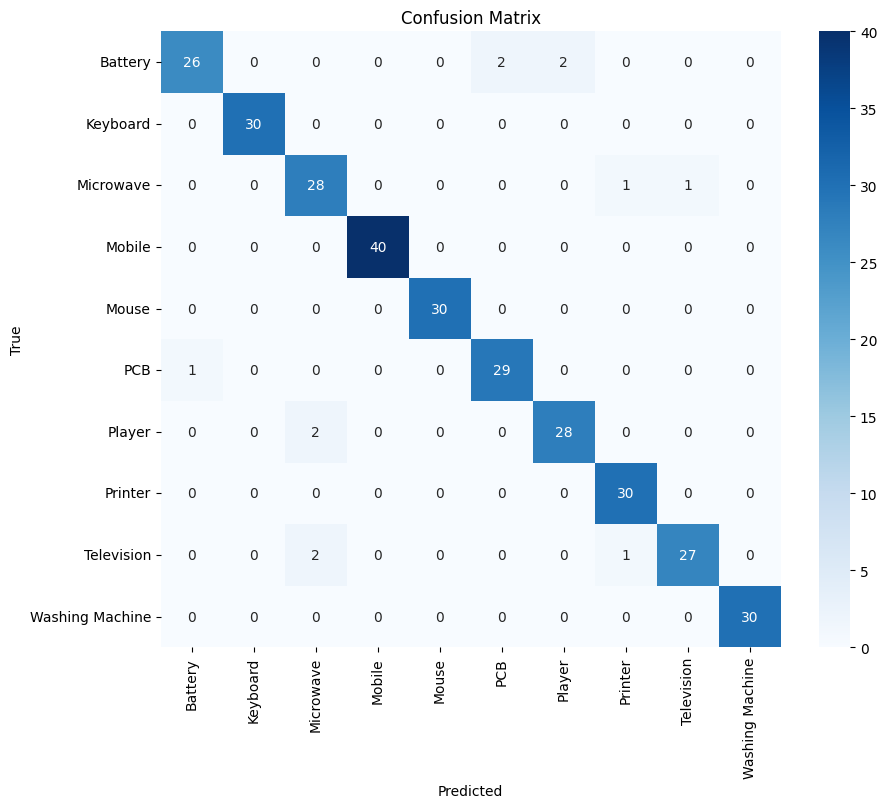

In [13]:
#  MODEL EVALUATION
test_loss, test_acc = model.evaluate(datatest)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

y_true = np.concatenate([y.numpy() for _, y in datatest], axis=0)
y_pred = np.argmax(model.predict(datatest), axis=1)

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# FINAL TESTING AND SAVE THE MODEL

In [14]:
# FINAL TESTING AND SAVE THE MODEL
model.save('efficientnetv2b0_ewaste_final.h5')
print("Keras model saved")

Keras model saved


# Save TFLite

In [15]:
# Save TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('efficientnetv2b0_ewaste_final.tflite', 'wb') as f:
    f.write(tflite_model)
print("TFLite model saved")

Saved artifact at '/tmp/tmpz82u9cg5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_270')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138594976151120: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138594976150928: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138594976148240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138594976153232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138594976148816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138594976151504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138594976153424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138594651242960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138594651244112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138594651245072: TensorSpec(shape=(), dtype=tf.resource, name

# Predictions on sample test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


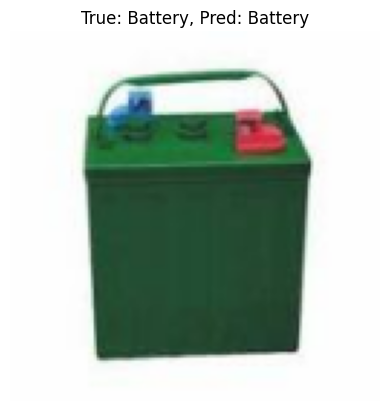

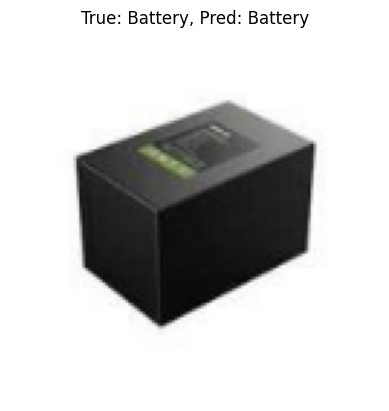

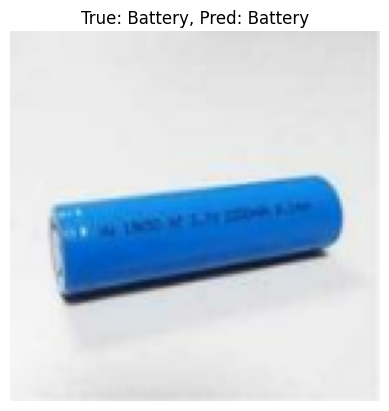

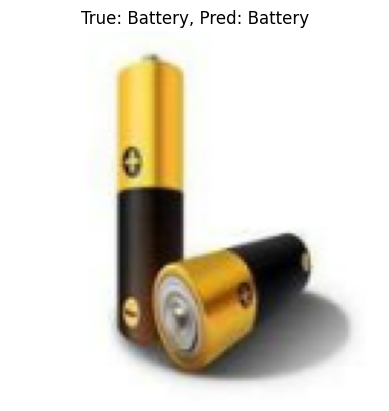

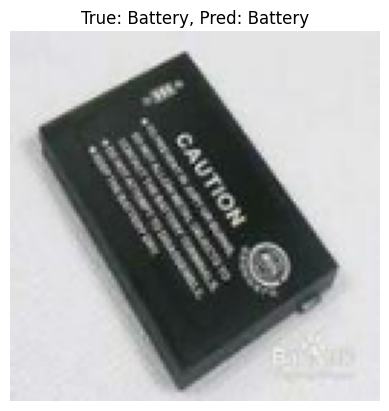

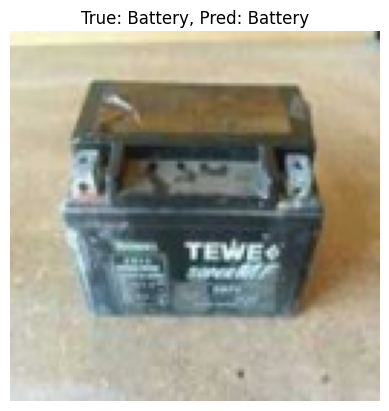

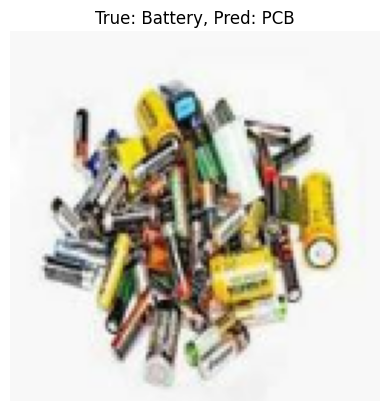

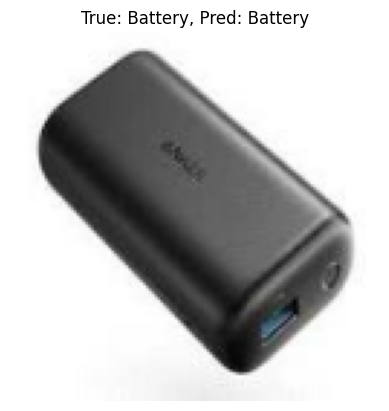

In [16]:
# Show predictions on sample test images
for images, labels in datatest.take(1):
    preds = model.predict(images)
    pred_classes = tf.argmax(preds, axis=1)
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_classes[i]]}")
        plt.axis("off")
        plt.show()

# Using CNN Model

In [17]:
# Normal CNN Model
normal_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=IMG_SIZE+(3,)),  # Simple rescaling
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

normal_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
normal_history = normal_model.fit(datatrain,
                                   validation_data=datavalid,
                                   epochs=15,
                                   callbacks=[early_stop, reduce_lr])

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.1358 - loss: 2.2654 - val_accuracy: 0.1867 - val_loss: 2.0728 - learning_rate: 0.0010
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.2451 - loss: 2.0675 - val_accuracy: 0.3267 - val_loss: 2.0186 - learning_rate: 0.0010
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.3169 - loss: 1.9402 - val_accuracy: 0.3100 - val_loss: 1.8574 - learning_rate: 0.0010
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.3235 - loss: 1.8553 - val_accuracy: 0.3733 - val_loss: 1.7331 - learning_rate: 0.0010
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.3490 - loss: 1.7900 - val_accuracy: 0.3933 - val_loss: 1.7310 - learning_rate: 0.0010
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.3539 - loss: 1.7752 - val_accuracy: 0.4100 - val_loss: 1.6510 - learning_rate: 0.0010
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.3729 - loss: 1.7356 - val_accuracy:

# Plot between CNN and EfficientNet

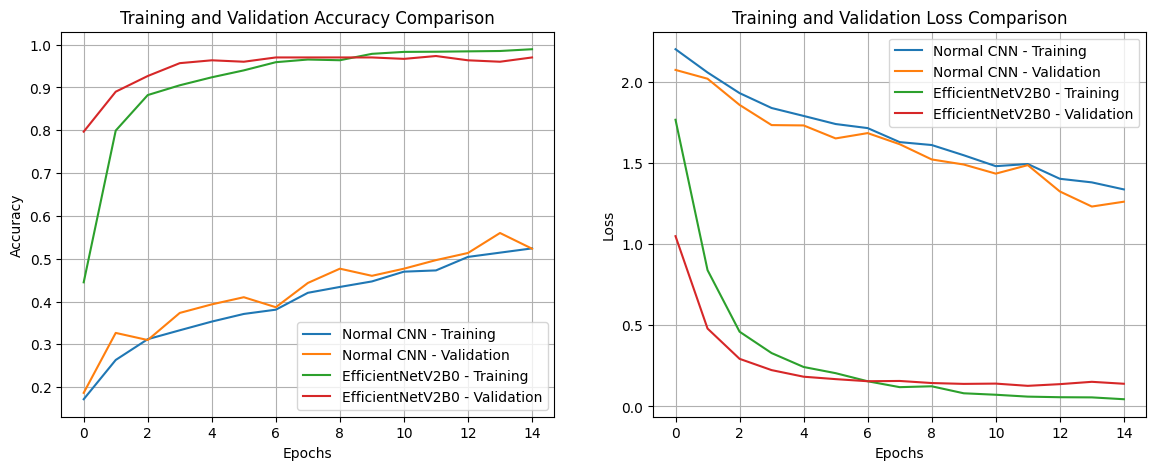

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(normal_history.history['accuracy'], label='Normal CNN - Training')
plt.plot(normal_history.history['val_accuracy'], label='Normal CNN - Validation')
plt.plot(history.history['accuracy'], label='EfficientNetV2B0 - Training')
plt.plot(history.history['val_accuracy'], label='EfficientNetV2B0 - Validation')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(normal_history.history['loss'], label='Normal CNN - Training')
plt.plot(normal_history.history['val_loss'], label='Normal CNN - Validation')
plt.plot(history.history['loss'], label='EfficientNetV2B0 - Training')
plt.plot(history.history['val_loss'], label='EfficientNetV2B0 - Validation')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [20]:
!pip install gradio tensorflow pillow

In [22]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.applications.efficientnet import preprocess_input

#  Load your saved Keras model
model = tf.keras.models.load_model('efficientnetv2b0_ewaste_final.h5')
class_names = [
    'Battery', 'Keyboard', 'Microwave', 'Mobile',
    'Mouse', 'PCB', 'Player', 'Printer',
    'Television', 'Washing Machine'
]

#  Prediction function
def classify_image(img):
    """Preprocess input image and make prediction."""
    img = img.resize((128, 128))
    img_array = np.asarray(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

#  Create Gradio Interface
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="E‑Waste Classifier",
    description="Upload an image of an e‑waste item for classification."
)

#  Launch the app
iface.launch(share=True)  # Enables a public link

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://80de40e225bc483c3d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
